In [18]:
# Load gemini
#from context import gemini
from gemini  import data, engine, helpers

# Global Imports
import pandas as pd
import numpy as np

# Build mean reversion strategy
#from talib.abstract import *
import talib

In [56]:
# Apply strategy to example
#df = pd.read_csv("data/BTC_USD.csv", header=0, index_col=0)
#df['date'] = pd.to_datetime(df['date'])
#df.head()

#TALIB SMA and EMA returns same results

# Higher timeframes (>= daily)
df = data.get_htf_candles("BTC_USD", "Bitfinex", "1-DAY", "2018-02-01 00:00:00", "2019-02-01 00:00:00")
df.head()

ema_20 = df['close'].ewm(span=20,min_periods=0,adjust=False,ignore_na=False).mean()
#talib.EMA(df['close'].values,20)
ema_60 = df['close'].ewm(span=60,min_periods=0,adjust=False,ignore_na=False).mean()
#talib.EMA(df['close'].values,60)
#print(ema_30, ema_90) 
df['EMA_20']= ema_20
df['EMA_60']= ema_60
df.head()

,date,low,high,open,close,volume,EMA_20,EMA_60
0,2018-02-01,8941.00000000,10336.00000000,10267.00000000,9181.00000000,77142.62000000,9181.00000000,9181.00000000
1,2018-02-02,7960.00000000,9213.00000000,9181.00000000,8890.90000000,119927.84000000,9153.37142857,9171.48852459
2,2018-02-03,8180.00000000,9499.00000000,8890.90000000,9225.00000000,50851.27000000,9160.19319728,9173.24299919
3,2018-02-04,7809.00000000,9410.00000000,9225.00000000,8185.20000000,67784.20000000,9067.33670230,9140.84814676
4,2018-02-05,6651.00000000,8380.00000000,8185.20000000,6947.20000000,129428.06000000,8865.41892113,9068.92525670


In [50]:
#Simple Stratergy to Check if 20 EMA goes below 60 Days EMA then Buy, 
# 20 days EMA rises above > 60 Days EMA Sell

# Step 1: Find the intersection points 
previous_20 = df['EMA_20'].shift(1)
previous_60 = df['EMA_60'].shift(1)

crossing = (((df['EMA_20'] <= df['EMA_60']) & (previous_20 >= previous_60))
            | ((df['EMA_20'] >= df['EMA_60']) & (previous_20 <= previous_60)))
df['crossing']=crossing
df.head()



,date,low,high,open,close,volume,EMA_20,EMA_60,crossing
0,2017-02-01,960.10000000,985.00000000,966.19000000,984.01000000,9400.31000000,984.01000000,984.01000000,False
1,2017-02-02,970.10000000,1010.50000000,985.97000000,1006.50000000,13657.81000000,986.15190476,984.74737705,True
2,2017-02-03,986.11000000,1020.50000000,1005.70000000,1013.00000000,14772.11000000,988.70886621,985.67369256,False
3,2017-02-04,1001.60000000,1040.00000000,1018.80000000,1031.80000000,10742.86000000,992.81278372,987.18603050,False
4,2017-02-05,995.10000000,1033.00000000,1030.10000000,1010.00000000,9699.74000000,994.44966146,987.93402950,False


In [51]:

def logic(account, lookback):
    try:
        lookback = helpers.period(lookback)
        today = lookback.loc(0)
        
    #selling 
        if(today.crossing==True):
            exit_price = today.close
            if(today.EMA_20 > today.EMA_60):
                for position in account.positions:
                    if position.type == 'long':
                        account.close_position(position, 1, exit_price)
                    
        #buying 
        if(today.crossing==True):
            
            entry_price = today.open
            risk = 1
            entry_capital = account.buying_power*risk
            if(today.EMA_20 < today.EMA_60):
                if entry_capital > 0:
                    account.enter_position('long', entry_capital, entry_price)
    
    except Exception as e:
        print(e)
        pass 
            

In [52]:
backtest = engine.backtest(df)

In [55]:
output = backtest.start(1000, logic)
output.head()

,benchmark_equity,strategy_equity,benchmark_return,strategy_return
date,,,,
2017-02-01,984.01000000,1000.00000000,nan,nan
2017-02-02,1006.50000000,1000.00000000,0.02285546,0.00000000
2017-02-03,1013.00000000,1000.00000000,0.00645802,0.00000000
2017-02-04,1031.80000000,1000.00000000,0.01855874,0.00000000
2017-02-05,1010.00000000,1000.00000000,-0.02112813,0.00000000


In [54]:
backtest.results()

-------------- Results ----------------

Buy and Hold : 265.85%
Net Profit   : 2658.46
Strategy     : -41.4%
Net Profit   : -413.95
Longs        : 4
sells        : 3
shorts       : 0
covers       : 0
--------------------
Total Trades : 7

---------------------------------------


In [40]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

Start date,2018-02-01
End date,2019-02-01
Total months,17
,Backtest
Annual return,-17.7%
Cumulative returns,-24.6%
Annual volatility,56.6%
Sharpe ratio,-0.06
Calmar ratio,-0.32
Stability,0.11
Max drawdown,-55.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,55.41,2018-09-04,2018-12-14,NaT,NaN
1,34.30,2018-04-24,2018-06-28,2018-08-24,89
2,25.85,2018-03-23,2018-04-06,2018-04-23,22
3,24.69,2018-02-03,2018-02-05,2018-02-14,8
4,4.91,2018-03-16,2018-03-17,2018-03-19,2


IndexError: invalid index

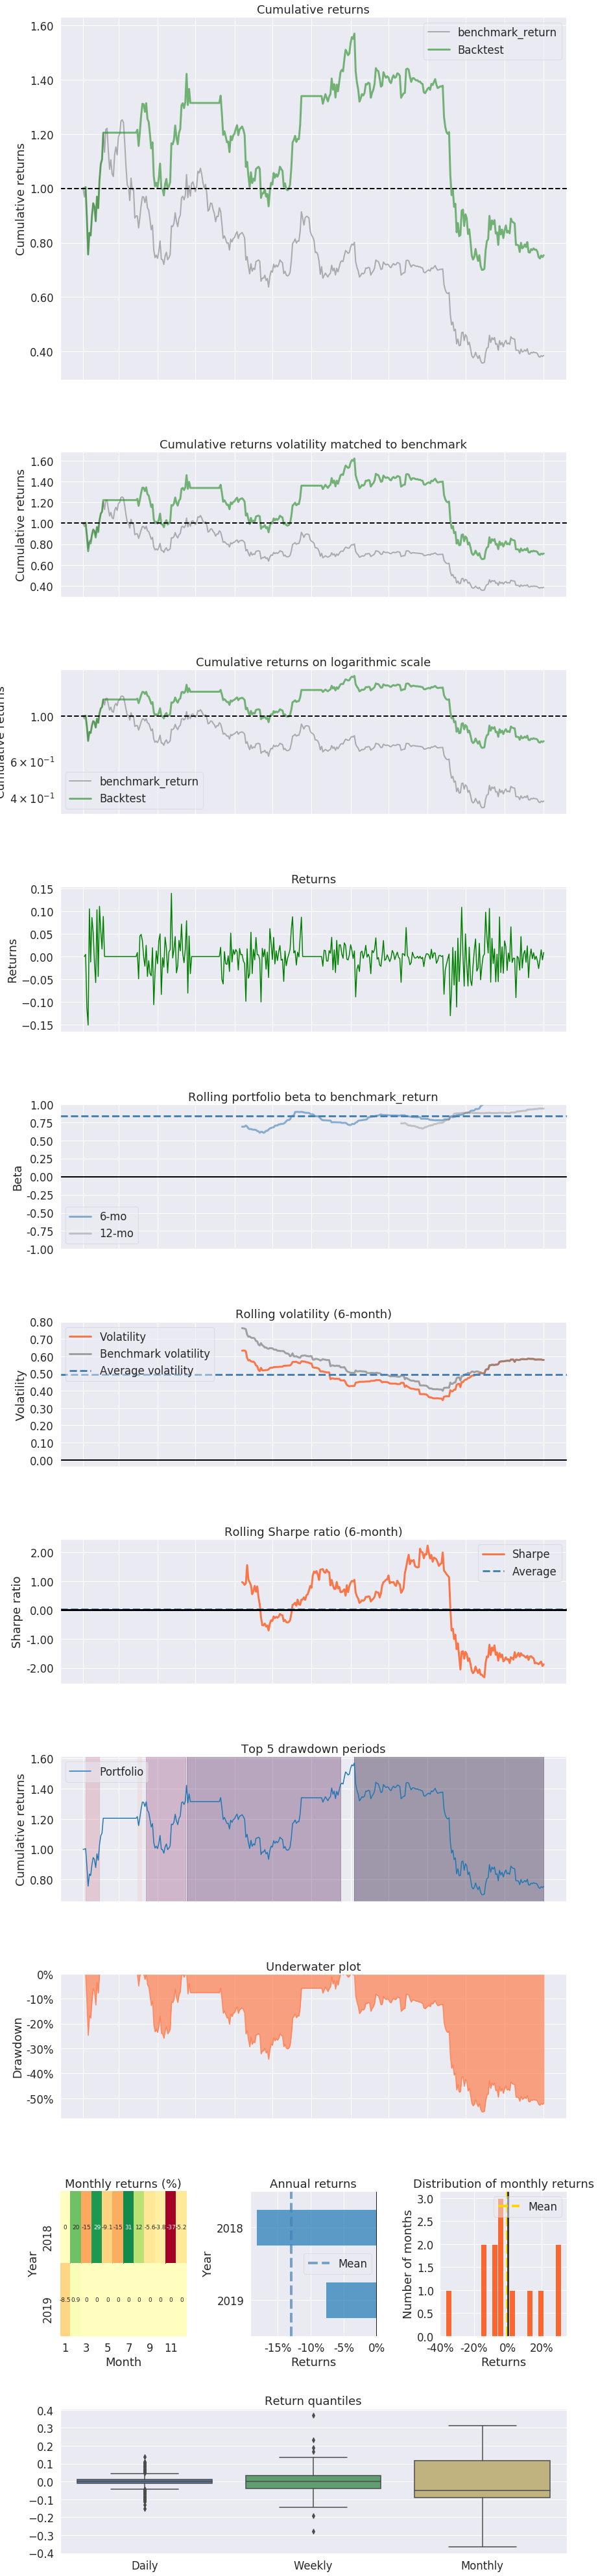

In [41]:
pf.create_returns_tear_sheet(output['strategy_return'], benchmark_rets=output['benchmark_return'])